In this notebook we cluster the measured target spectra for each species.

In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import feature
from yellowbrick.cluster.elbow import kelbow_visualizer

import sys, errno  


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [3]:

palette = sns.color_palette('Paired', n_colors=14)
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 14
BIGGER_SIZE = 15
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [4]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/'
kpath = f'{letter_drive}:/AFKABAN/Krill_270123/'

# Read saved df

In [5]:
a_df = pd.read_feather(apath+'/a_tilt_df.feather')
p_df = pd.read_feather(ppath+'/p_tilt_df.feather')
p2_df = pd.read_feather(p2path+'/p2_tilt_df.feather')
pb_df = pd.read_feather(pbpath+'/pb_tilt_df.feather')
#k_df = pd.read_feather(kpath+'/k_tilt_df.feather')

# Cluster spectra
sort by frequency bandwith

In [41]:
def select_ts_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(np.isnan(df['200.000']))[0]
    ts_s_120 = np.where(df.columns.values=='94.000')[0][0] #remove 5% of spectra on either side b/c ramping
    ts_e_120 = np.where(df.columns.values=='160.000')[0][0]
    
    ind_200 = np.where(np.isnan(df['120.000']))[0]
    ts_s_200 = np.where(df.columns.values=='189.000')[0][0]
    ts_e_200 = np.where(df.columns.values=='251.000')[0][0]

    df_120 = df.iloc[ind_120,ts_s_120:ts_e_120]
    df_200 = df.iloc[ind_200,ts_s_200:ts_e_200]
    
    return df_120, df_200

In [42]:
a_df_120, a_df_200 = select_ts_bandwidth(a_df)
p_df_120, p_df_200 = select_ts_bandwidth(p_df)
p2_df_120, p2_df_200 = select_ts_bandwidth(p2_df)
pb_df_120, pb_df_200 = select_ts_bandwidth(pb_df)

### Select a df and run clustering

In [43]:
def kmean_spectra(df, num_clus=6):
    'Function to run kmean clusering on target spectra of a species'
    # Set up kmeans
    kmeans = KMeans(n_clusters=num_clus)
    
    # Normalize by the median of each target spectra
    df_norm = df.div(df.median(axis=1), axis=0)
    
    # Fit data
    y_kmean = kmeans.fit_predict(df_norm)

    return y_kmean, kmeans
    

In [44]:
num_clus=5

a_120_ykmean, k = kmean_spectra(a_df_120, num_clus=num_clus)
p_120_ykmean, k = kmean_spectra(p_df_120, num_clus=num_clus)
p2_120_ykmean, k = kmean_spectra(p2_df_120, num_clus=num_clus)


a_200_ykmean, k = kmean_spectra(a_df_200, num_clus=num_clus)
p_200_ykmean, k = kmean_spectra(p_df_200, num_clus=num_clus)
p2_200_ykmean, k = kmean_spectra(p2_df_200, num_clus=num_clus)

C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [45]:
# Add kmeans group to main dataframe
def add_ykmean(df, y_120, y_200, df_f120, df_f200):
    y_120 = pd.DataFrame(y_120, index=df_f120.index, columns=['y_kmean'])
    y_200 = pd.DataFrame(y_200+6, index=df_f200.index, columns=['y_kmean'])
    y = pd.concat([y_120,y_200])
    df['y_kmean']=y
    df['abs_tilt'] = np.abs(df['tilt'])
    return df

In [46]:
a_df = add_ykmean(a_df, a_120_ykmean, a_200_ykmean, a_df_120, a_df_200)
p_df = add_ykmean(p_df, p_120_ykmean, p_200_ykmean, p_df_120, p_df_200)
p2_df = add_ykmean(p2_df, p2_120_ykmean, p2_200_ykmean, p2_df_120, p2_df_200)

### Plot kmeans clustering results

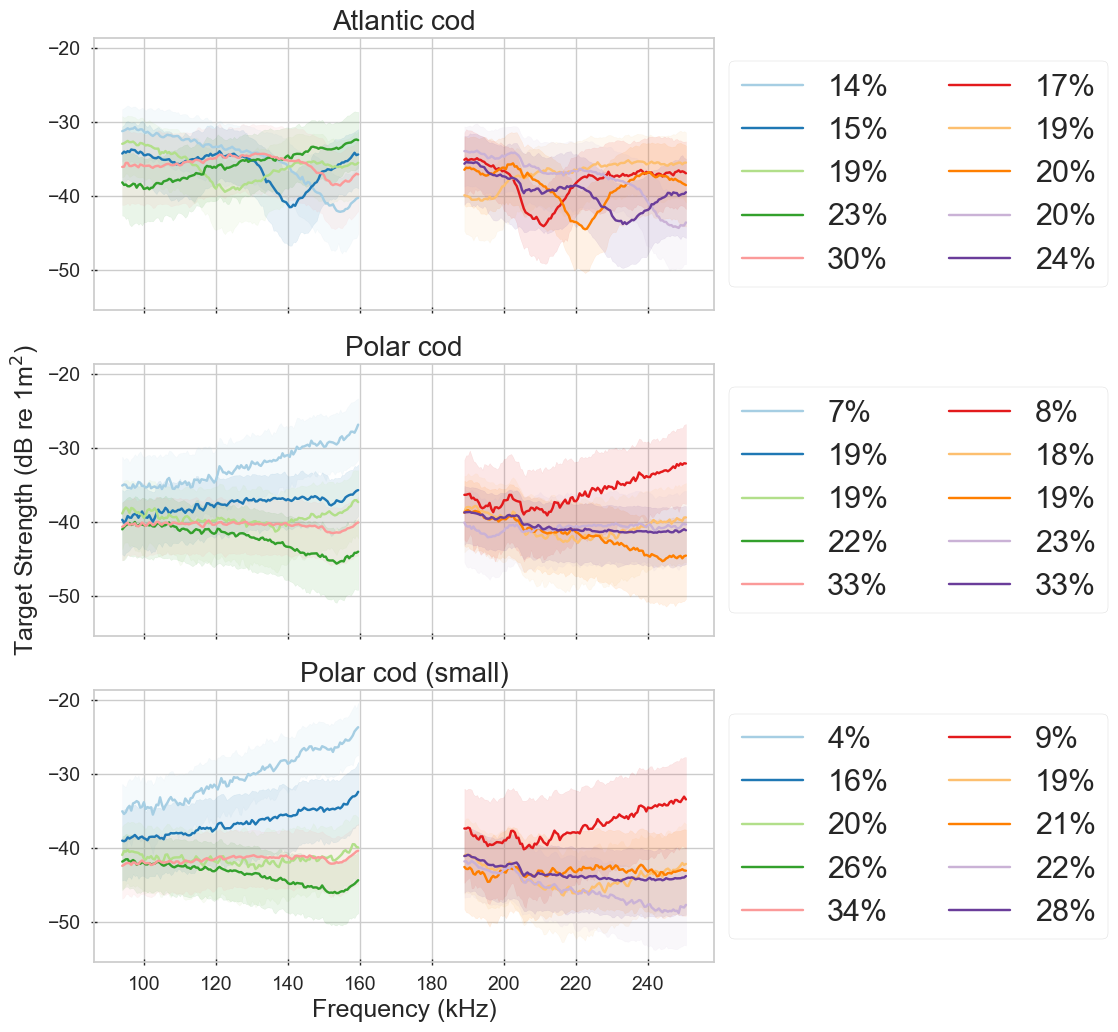

In [47]:
df_list = [a_df_120,p_df_120,p2_df_120]
y_list = [a_120_ykmean, p_120_ykmean, p2_120_ykmean]
df2_list = [a_df_200,p_df_200,p2_df_200]
y2_list = [a_200_ykmean, p_200_ykmean, p2_200_ykmean]
    
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod (small)']
fig,ax = plt.subplots(3,1, figsize=(8,12), sharex=True, sharey=True)
axes = ax.flatten()
N1 = np.zeros(num_clus)
N2 = np.zeros(num_clus)

for i_df in range(len(df_list)):
    # 120 kHz
    df1 = df_list[i_df]
    y_kmean1 = y_list[i_df]
    freqs_120 = df1.columns.unique().values.astype(np.float64)

    for i_cluster in range(num_clus):
        i_ts1 = np.where(y_kmean1==i_cluster)[0]
        N1[i_cluster] = len(i_ts1)
        
    Nsort_ind = np.argsort(N1)
    i_c = 0
    for i_cluster in Nsort_ind:
        
        i_ts1 = np.where(y_kmean1==i_cluster)[0]
        axes[i_df].plot(freqs_120,np.median(df1.iloc[i_ts1,:].T,axis=1), c=palette[i_c], label=f'{N1[i_cluster]*100/len(df1):.0f}%')
        axes[i_df].fill_between(freqs_120,df1.iloc[i_ts1,:].quantile(q=0.25), df1.iloc[i_ts1,:].quantile(q=0.75), color=palette[i_c], alpha=0.1)
        i_c += 1
        
    # 200 kHz
    df2 = df2_list[i_df]
    y_kmean2 = y2_list[i_df]
    freqs_200 = df2.columns.unique().values.astype(np.float64)

    for i_cluster in range(num_clus):
        i_ts2 = np.where(y_kmean2==i_cluster)[0]
        N2[i_cluster] = len(i_ts2) 
        
    N2sort_ind = np.argsort(N2)
    i_c = 0
    for i_cluster in N2sort_ind:
        i_ts2 = np.where(y_kmean2==i_cluster)[0]
        axes[i_df].plot(freqs_200,np.median(df2.iloc[i_ts2,:].T,axis=1), c=palette[i_c+num_clus], label=f'{N2[i_cluster]*100/len(df2):.0f}%')
        axes[i_df].fill_between(freqs_200,df2.iloc[i_ts2,:].quantile(q=0.25), df2.iloc[i_ts2,:].quantile(q=0.75), color=palette[i_c+num_clus], alpha=0.1)
        i_c +=1
        
    axes[i_df].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=22, frameon=True)
    axes[i_df].set_title(f'{name_list[i_df]}', fontsize=20)
    
axes[2].set_xlabel('Frequency (kHz)', fontsize=18)
axes[1].set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=18)

fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/PhDdocs/ConferencesMeetings/WGFAST2023/clusters.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight')

In [39]:
Nsort_ind

array([2, 1, 3, 4, 0], dtype=int64)

Observations:
- Atlanctic cod has a larger (~5dB) dip in the traget spectra that shifts horizontally. What causes the shift?
- Polar cod (both experiments are similar, great start, has no consistent dips but positive, zero or negative slope.
- Pandalus does not have enough targets for clustering. Too much variability for the few amount of tracked detections. But Pandalus can be differentiated with a threshold
- clusters still have a lot of variability!

Can we use to clusters as centroids of clusters for classification? 

Note: The clusters in 120 and 200 are not related! They have been clustered independently. Each tracked SED (calibrated beam compensared TS) is unaveraged or smoothed.

# Can we correlate cluster number to tilt angle??

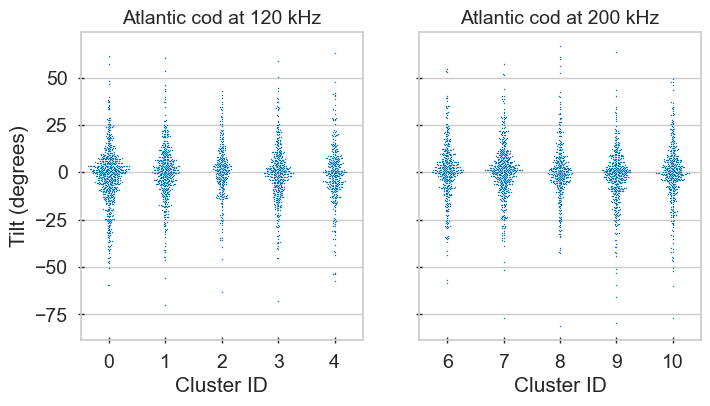

In [40]:
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True)
axes = ax.flatten()
sns.swarmplot(a_df.iloc[a_df_120.index.values,:], x='y_kmean', y='tilt', ax = axes[0], size=1)
sns.swarmplot(a_df.iloc[a_df_200.index.values,:], x='y_kmean', y='tilt', ax = axes[1], size=1)

axes[0].set(title = 'Atlantic cod at 120 kHz', xlabel='Cluster ID', ylabel='Tilt (degrees)')
axes[1].set(title = 'Atlantic cod at 200 kHz', xlabel='Cluster ID', ylabel='Tilt (degrees)');

Cluster number and orientation does not seem to be related.

Similar distributions for all species, both frequency bandwidths and each cluster.

# Can we correlate cluster number to track number?? 
Do detection within the same track tend to be clustered together? If yes, it would show that broadband variability may be explained by individual fish length, material properties or other scattering properties that are relatively consistent for a single fish.

In [15]:
count=0

In [16]:
## Get region list for each frequency bandwidth
def select_region_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(np.isnan(df['200.000']))[0]
    ts_s_120 = np.where(df.columns.values=='90.000')[0][0]
    ts_e_120 = np.where(df.columns.values=='162.000')[0][0]
    
    ind_200 = np.where(np.isnan(df['120.000']))[0]
    ts_s_200 = np.where(df.columns.values=='185.000')[0][0]
    ts_e_200 = np.where(df.columns.values=='255.000')[0][0]
    
    reg_120 = df['Region_name'][ind_120] 
    reg_200 = df['Region_name'][ind_200] 
    
    return reg_120, reg_200

In [17]:
a_reg_120, a_reg_200 = select_region_bandwidth(a_df)
p_reg_120, p_reg_200 = select_region_bandwidth(p_df)
p2_reg_120, p2_reg_200 = select_region_bandwidth(p2_df)
pb_reg_120, pb_reg_200 = select_region_bandwidth(pb_df)

In [18]:
a_reg_120.unique()

array(['Region 1', 'Region 10', 'Region 100', 'Region 101', 'Region 102',
       'Region 103', 'Region 104', 'Region 105', 'Region 106',
       'Region 107', 'Region 108', 'Region 109', 'Region 11',
       'Region 110', 'Region 111', 'Region 112', 'Region 113',
       'Region 114', 'Region 115', 'Region 116', 'Region 117',
       'Region 118', 'Region 119', 'Region 12', 'Region 120',
       'Region 121', 'Region 122', 'Region 123', 'Region 124',
       'Region 125', 'Region 126', 'Region 127', 'Region 128',
       'Region 129', 'Region 13', 'Region 130', 'Region 131',
       'Region 132', 'Region 133', 'Region 134', 'Region 135',
       'Region 136', 'Region 137', 'Region 138', 'Region 139',
       'Region 14', 'Region 140', 'Region 141', 'Region 142',
       'Region 143', 'Region 144', 'Region 145', 'Region 146',
       'Region 147', 'Region 148', 'Region 149', 'Region 15',
       'Region 150', 'Region 151', 'Region 152', 'Region 153',
       'Region 154', 'Region 155', 'Region 156', 

In [19]:
# Select dataset
df_list = [a_df_120,a_df_200,p_df_120,p_df_200,p2_df_120,p2_df_200]
y_list = [a_120_ykmean,a_200_ykmean, p_120_ykmean,p_200_ykmean, p2_120_ykmean,p2_200_ykmean]
regions_list = df_list = [a_reg_120,a_reg_200,p_reg_120,p_reg_200,p2_reg_120,p2_reg_200]

select = 5
df=df_list[select]
y_kmean = y_list[select]
regions = regions_list[select]


#---------
all_regions = regions.unique()
n_cluster_track = {}
cluster_counts ={}
n_cluster_ratio = []
n_reg = []
biggest_cluster_ratio = []

count = 0
for i_reg in all_regions:
    ind_reg = np.where(regions==i_reg)[0]
    if len(ind_reg)>2:
        y_reg = y_kmean[ind_reg]

        n_cluster_track[count], cluster_counts[count] = np.unique(y_reg,return_counts=True)
        
        biggest_cluster_ratio = np.append(biggest_cluster_ratio,max(cluster_counts[count])/len(ind_reg))

        n_cluster_ratio = np.append(n_cluster_ratio,(len(n_cluster_track[count])/len(ind_reg)))
        n_reg = np.append(n_reg, len(ind_reg))
        count += 1

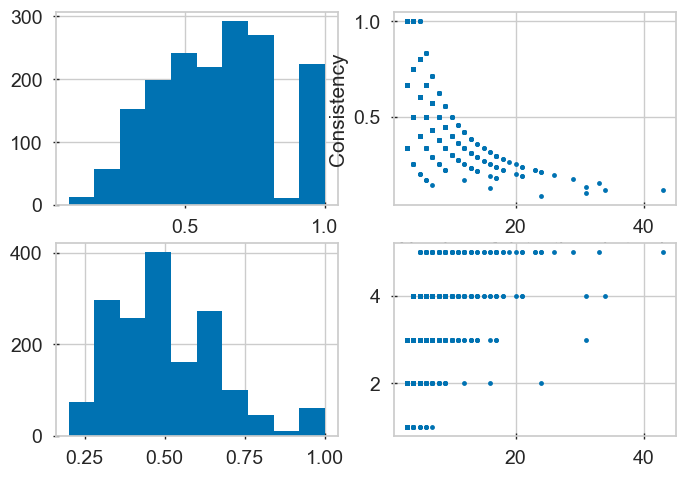

In [20]:
fig,ax = plt.subplots(2,2)
axes = ax.flatten()
axes[0].hist(n_cluster_ratio)

axes[1].plot(n_reg,n_cluster_ratio, '.')
axes[1].set(xlabel='Number of detections in track',ylabel='Consistency');

axes[2].hist(biggest_cluster_ratio)

axes[3].plot(n_reg,n_cluster_ratio*n_reg, '.')

#### How many tracks contain one cluster?

In [21]:
for i in range(len(n_cluster_track)):


IndentationError: expected an indented block (4205795690.py, line 1)

In [22]:
n_cluster_track[1]

array([0, 3, 4])

Haven't proved it yet but it really doesnt seem to be a driving factor

## Try pca? in Python

In [23]:
le = LabelEncoder() # Maps labels -> int (e.g. Atlantic cod -> 0, Polar cod -> 1)
a_df['RegionID'] = le.fit_transform(a_df.Region_name)

In [24]:
sub_df = np.array(a_df[['tilt','RegionID','y_kmean','abs_tilt']])

In [25]:
std_scaler = StandardScaler()
 
df_scaled = std_scaler.fit_transform(sub_df['tilt'])
df_scaled = pd.DataFrame(df_scaled, columns=[
  'tilt','RegionID','y_kmean','abs_tilt'])
 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
X = df_scaled[~np.any(np.isnan(sub_df),axis=1)]

In [26]:
X

NameError: name 'X' is not defined

In [27]:
pca = PCA(n_components=4)

In [28]:
pca.fit(X)

NameError: name 'X' is not defined

In [29]:
rng = np.random.RandomState(0)
n_samples = len(X)
pca = PCA(n_components=4).fit(X)


plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {X.columns[i]}",
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

NameError: name 'X' is not defined

# Storage Area

### Elbow algorithm to find optimal clusters

Run elbow algorithm for optimal number of clusters.

Optimal value is found at the "elbow" of the distortion results.

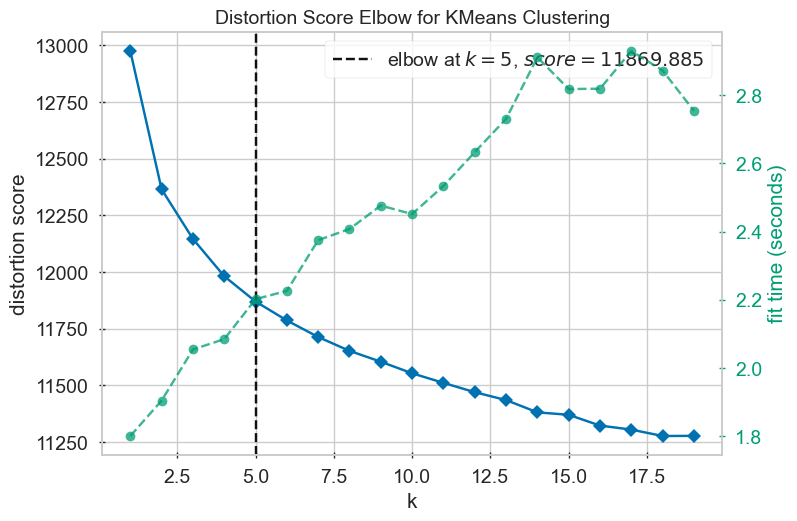

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=19), k=(1, 20))

In [31]:
#Use the quick method and immediately show the figure
df = p_df_200
df_norm = df.div(df.median(axis=1), axis=0)
kelbow_visualizer(KMeans(), df_norm, k=(1,20))

N=6